In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
# Install necessary Python packages
#!pip install numpy pandas matplotlib

# Install ROS base packages
!apt-get update
!apt-get install ros-noetic-ros-base

# Install additional ROS Python packages
!pip install rospkg catkin_pkg


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package ros-noetic-ros-base


In [7]:
import cv2
import os
from decimal import Decimal
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd

In [8]:
ground_truth = pd.read_csv("GT_Translations.csv")
ground_truth

,translation_x,translation_y,frame_numbers
0,4.283033e-10,5.734970e-11,frame_0
1,-3.167683e-01,7.047308e-03,frame_1
2,-3.775978e-01,8.400614e-03,frame_2
3,-3.775978e-01,8.400614e-03,frame_3
4,-3.775978e-01,8.400614e-03,frame_4
...,...,...,...
3317,2.569888e+01,9.769882e+00,frame_3317
3318,2.569888e+01,9.769882e+00,frame_3318
3319,2.569888e+01,9.769882e+00,frame_3319
3320,2.569888e+01,9.769882e+00,frame_3320


## Görüntülerin ve kalibrasyon parametrelerinin değişkene atanması

In [9]:
# img_path = "/content/drive/MyDrive/Teknofest/Datasets/Pozisyon_Kestirimi/Oturum1_Part2"
img_path = "/content/frame"
file_names = sorted([file_name for file_name in os.listdir(img_path) if file_name.endswith(('.jpg', '.png'))])

# Görüntü dosya yollarını bir listeye ekleyin
image_files = [os.path.join(img_path, file_name) for file_name in file_names]

# Görüntüleri bir diziye ekleyin
images = [cv2.imread(image) for image in image_files]

#images = [cv2.imread(image) for image in image_files[:10]]

print(len(images))

200


In [10]:
intrinsicMatrix = None
focalLength = None
principalPoint = None
radialDistortion = (-0.0091, 0.0666)
tangentialDistortion = (0,0)
imageSize = None
rotationMatrices = None
translationVectors = None
meanReprojectionError = None
reprojectionErrors = None
reprojectedPoints = None
numPatterns = None
worldPoints = None
worldUnits = None
estimateSkew = None
numRadialDistortionCoefficients = None
estimateTangentialDistortion = None

# /content/drive/MyDrive/Teknofest/Datasets/Pozisyon_Kestirimi/kalibrasyon.txt
with open('Kalibrasyon_Parametreleri.txt', 'r') as file:
    file_contents = file.readlines()


# Değişkenlere atama
for line in file_contents:
    if 'IntrinsicMatrix' in line:
      intrinsicMatrix = [[0.0 for _ in range(int(line.split(':')[1][4]))] for _ in range(int(line.split(':')[1][2]))]
      print(intrinsicMatrix)
    elif 'FocalLength' in line:
      focalLength = (float(line.split(':')[1].split()[0][1:]),float(line.split(':')[1].split()[1][:-1]))
      print(focalLength)
    elif 'PrincipalPoint' in line:
      principalPoint = (float(line.split(':')[1].split()[0][1:]),float(line.split(':')[1].split()[1][:-1]))
      print(principalPoint)
    # elif 'RadialDistortion' in line:
    #   print(float(line.split(':')[1].split()[1][:-1]))
    #   radialDistortion = (float(line.split(':')[1].split()[0][1:]),float(line.split(':')[1].split(" ")[1][:-1]))
    #   print(radialDistortion)
    # elif 'TangentialDistortion' in line:
    #   tangentialDistortion = (float(line.split(':')[1].split()[0][1:]),float(line.split(':')[1].split()[1][:-1]))
    #   print(tangentialDistortion)
    elif 'ImageSize' in line:
      imageSize = (int(line.split(':')[1].split()[0][1:]),int(line.split(':')[1].split()[1][:-1]))
      print(imageSize)
    elif 'RotationMatrices' in line:
      part = line.split(':')[1].split(" ")[1].split("×")
      rotationMatrices = [[ [0.0 for col in range(int(part[2]))] for col in range(int(part[1]))] for row in range(int(part[0][1:]))]
      print(rotationMatrices)
    elif 'TranslationVectors' in line:
      part = line.split(':')[1].split(" ")[1].split("×")
      translationVectors = [[0.0]*int(part[1])]*int(part[0][1:])
      print(translationVectors)
    elif 'MeanReprojectionError' in line:
      meanReprojectionError = float(line.split(':')[1])
      print(meanReprojectionError)
    elif 'ReprojectionErrors' in line:
      part = line.split(':')[1].split(" ")[1].split("×")
      reprojectionErrors = [[ [0.0 for col in range(int(part[2]))] for col in range(int(part[1]))] for row in range(int(part[0][1:]))]
      print(reprojectionErrors)
    elif 'ReprojectedPoints' in line:
      part = line.split(':')[1].split(" ")[1].split("×")
      reprojectedPoints = [[ [0.0 for col in range(int(part[2]))] for col in range(int(part[1]))] for row in range(int(part[0][1:]))]
      print(reprojectedPoints)
    elif 'NumPatterns' in line:
      numPatterns = int(line.split(':')[1])
      print(numPatterns)
    elif 'WorldPoints' in line:
      part = line.split(':')[1].split(" ")[1].split("×")
      worldPoints = [[0.0]*int(part[1])]*int(part[0][1:])
      print(worldPoints)
    elif 'WorldUnits' in line:
      worldUnits = line.split(':')[1].replace("'"," ").strip()
      print(worldUnits)
    elif 'EstimateSkew' in line:
      estimateSkew = int(line.split(':')[1])
      print(estimateSkew)
    elif 'NumRadialDistortionCoefficients' in line:
      numRadialDistortionCoefficients = int(line.split(':')[1])
      print(numRadialDistortionCoefficients)
    elif 'EstimateTangentialDistortion' in line:
      estimateTangentialDistortion = int(line.split(':')[1])
      print(estimateTangentialDistortion)

[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
(1413.3, 1418.8)
(950.0639, 543.3796)
(1080, 1920)
[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

##### Intrinsic Matrix değerlerinin verlmesi

In [11]:
intrinsicMatrix[0][0] = focalLength[0]
intrinsicMatrix[1][1] = focalLength[1]
intrinsicMatrix[0][2] = principalPoint[0]
intrinsicMatrix[1][2] = principalPoint[1]
intrinsicMatrix[2][2] = 1
intrinsicMatrix

[[1413.3, 0.0, 950.0639], [0.0, 1418.8, 543.3796], [0.0, 0.0, 1]]

### Görüntülerin Ön İşlemesi (Gri Tonlama)

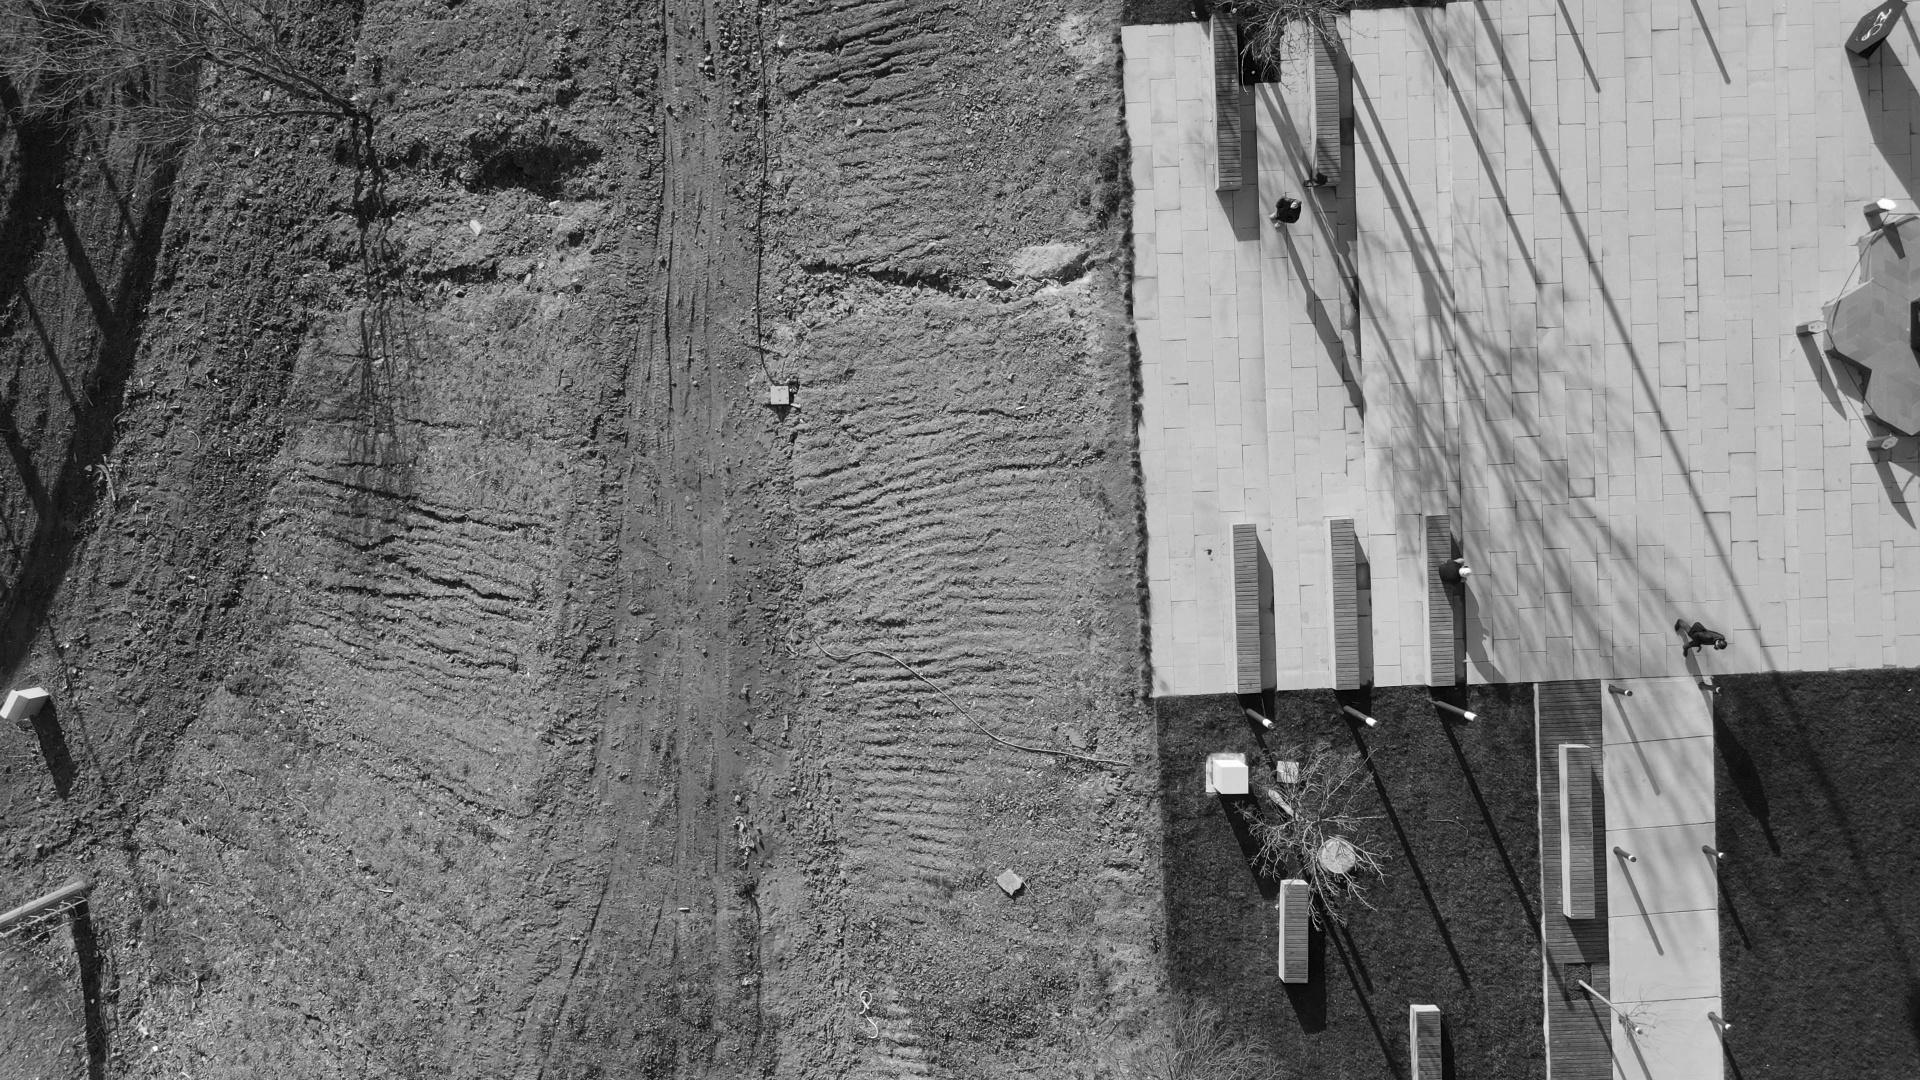

In [12]:

for i, img in enumerate(images):
    # Görüntüyü gri tona dönüştür
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if(i == 1):
      cv2_imshow(gray_img)
    # Gri tona dönüştürülmüş görüntüyü aynı indeksteki görüntü ile güncelle
    images[i] = gray_img

In [13]:
flow_params = dict(pyr_scale=0.8, levels=5, winsize=15, iterations=5, poly_n=5, poly_sigma=1.2, flags=0)


flows = []
for i in range(1,len(images)):
# Optik akışı hesapla
  flow = cv2.calcOpticalFlowFarneback(images[i-1], images[i], None, **flow_params)
  flows.append(flow)

  if (i%5 == 0):

    # Optik akış vektörlerini görüntü üzerinde çiz
    h, w = images[i-1].shape[:2]  # Görüntü boyutu
    y, x = np.mgrid[0:h:10, 0:w:10].reshape(2, -1)  # Optik akış vektörlerini çizmek için örnek noktaları al
    flow_x, flow_y = flow[y, x].T  # Akış vektörlerini al
    flow_x = flow_x.astype(np.int32)  # Tamsayıya dönüştür
    flow_y = flow_y.astype(np.int32)  # Tamsayıya dönüştür
    lines = np.vstack([x, y, x + flow_x, y + flow_y]).T.reshape(-1, 2, 2)  # Akış vektörlerini çizgiye dönüştür
    line_color = (0, 255, 0)  # Yeşil renk
    line_thickness = 1
    for (x1, y1), (x2, y2) in lines:
        cv2.line(images[i-1], (x1, y1), (x2, y2), line_color, line_thickness)

    # Görüntüyü göster
    #cv2_imshow(images[i-1])


In [14]:
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
import joblib

def estimate_camera_motion(optical_flow_vectors, model_path_x='ransac_x.pkl', model_path_y='ransac_y.pkl'):
    # Optik akış vektörlerini x ve y bileşenleri olarak ayırın
    x = optical_flow_vectors[:, 0]
    y = optical_flow_vectors[:, 1]
    rh_x = np.median(np.abs(x - np.median(x)))
    rh_y = np.median(np.abs(y - np.median(y)))

    if os.path.exists(model_path_x) and os.path.exists(model_path_y):
        ransac_x = joblib.load(model_path_x)
        ransac_y = joblib.load(model_path_y)
    else:
        ransac_x = RANSACRegressor(min_samples=0.1, residual_threshold=rh_x, max_trials=750, stop_score=0.95)
        ransac_y = RANSACRegressor(min_samples=0.1, residual_threshold=rh_y, max_trials=750, stop_score=0.95)

        X = np.arange(len(x)).reshape(-1, 1)

        ransac_x.fit(X, x)
        ransac_y.fit(X, y)

        joblib.dump(ransac_x, model_path_x)
        joblib.dump(ransac_y, model_path_y)

    translation_x = ransac_x.estimator_.coef_
    translation_y = ransac_y.estimator_.coef_
    translation = np.array([translation_x[0], translation_y[0]])

    return translation

def visualize_optical_flow_and_motion(optical_flow_vectors, translation):
    # Optik akış vektörlerini ve tahmin edilen hareketi görselleştir
    x = optical_flow_vectors[:, 0]
    y = optical_flow_vectors[:, 1]

    plt.figure(figsize=(10, 6))
    plt.quiver(np.arange(len(x)), np.zeros_like(x), x, y, angles='xy', scale_units='xy', scale=1, color='r', label='Optical Flow Vectors')
    plt.quiver(np.arange(len(x)), np.zeros_like(x), np.ones_like(x) * translation[0], np.ones_like(y) * translation[1], angles='xy', scale_units='xy', scale=1, color='b', label='Estimated Translation')
    plt.legend()
    plt.title('Optical Flow Vectors and Estimated Translation')
    plt.xlabel('Index')
    plt.ylabel('Flow')
    plt.grid()
    plt.show()

pixel_size_x = imageSize[0] / focalLength[0]
pixel_size_y = imageSize[1] / focalLength[1]

# Dönüşüm faktörünü hesaplama (conversion factor)
conversion_factor = np.array([1 / pixel_size_x, 1 / pixel_size_y])
print(conversion_factor)

current_position = np.array([0.0, 0.0])  # Başlangıç konumu (0,0)

#print("Start position is: (0,0)")
#for flow in flows:
#  flattened_optical_flow_vectors = np.reshape(flow, (-1, 2))
#  estimated_translation = estimate_camera_motion(flattened_optical_flow_vectors)
#  # visualize_optical_flow_and_motion(flattened_optical_flow_vectors, estimated_translation)
#  print(estimated_translation)
#  current_position+= (estimated_translation * conversion_factor)
#  print("Current Position Is: (", current_position[0],",",current_position[1],")")
## Optik akış vektörlerini içeren bir numpy dizisi örneği
#flattened_optical_flow_vectors = np.reshape(flows[1], (-1, 2))
## Kameranın hareketini tahmin etmek için RANSAC kullanarak çağırın
#estimated_translation = estimate_camera_motion(flattened_optical_flow_vectors)

#print("Estimated translation:", estimated_translation)

[1.30861111 0.73895833]


In [11]:
# Install ROS base packages
!apt-get update
!apt-get install ros-noetic-ros-base

# Install additional ROS Python packages
!pip install rospkg catkin_pkg


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package ros-noetic-ros-base


In [15]:
import os
import numpy as np
import pandas as pd

def save_trajectory_to_tum_format(trajectory, filename):
    """
    Save trajectory to a file in TUM format.
    """
    with open(filename, 'w') as file:
        for i, (t, pose) in enumerate(trajectory):
            file.write(f"{t} {pose[0]} {pose[1]} 0.0 0.0 0.0 0.0 1.0\n")

def get_ground_truth_trajectory(ground_truth_csv):
    """
    Load ground truth trajectory from a CSV file.
    """
    ground_truth = pd.read_csv(ground_truth_csv)
    trajectory = []
    for index, row in ground_truth.iterrows():
        t = int(row['frame_numbers'].split('_')[1])
        pose = np.array([row['translation_x'], row['translation_y']])
        trajectory.append((t, pose))
    return trajectory


def get_estimated_trajectory(flows, conversion_factor):
    """
    Compute estimated trajectory from optical flow vectors.
    """
    current_position = np.array([0.0, 0.0])
    trajectory = []
    for i, flow in enumerate(flows):
        flattened_optical_flow_vectors = np.reshape(flow, (-1, 2))
        estimated_translation = estimate_camera_motion(flattened_optical_flow_vectors)
        current_position += (estimated_translation * conversion_factor)
        print("i: ",i)
        print("current_position : ",current_position)
        print("estimated_translation : ", estimated_translation)

        trajectory.append((i, current_position.copy()))
    return trajectory

# Define paths
ground_truth_csv = "GT_Translations.csv"
estimated_trajectory_file = "stamped_traj_estimate.txt"
ground_truth_trajectory_file = "stamped_groundtruth.txt"

# Get ground truth trajectory
ground_truth_trajectory = get_ground_truth_trajectory(ground_truth_csv)

# Compute estimated trajectory
estimated_trajectory = get_estimated_trajectory(flows, conversion_factor)

# Save trajectories to TUM format
save_trajectory_to_tum_format(ground_truth_trajectory, ground_truth_trajectory_file)
save_trajectory_to_tum_format(estimated_trajectory, estimated_trajectory_file)


i:  0
current_position :  [ 5.00478985e-08 -2.11140363e-09]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  1
current_position :  [ 1.00095797e-07 -4.22280726e-09]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  2
current_position :  [ 1.50143695e-07 -6.33421089e-09]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  3
current_position :  [ 2.00191594e-07 -8.44561452e-09]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  4
current_position :  [ 2.50239492e-07 -1.05570182e-08]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  5
current_position :  [ 3.00287391e-07 -1.26684218e-08]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  6
current_position :  [ 3.50335289e-07 -1.47798254e-08]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  7
current_position :  [ 4.00383188e-07 -1.68912290e-08]
estimated_translation :  [ 3.82450509e-08 -2.85727021e-09]
i:  8
current_position :  [ 4.50431086e-07 -1.90

In [16]:
# Clone the rpg_trajectory_evaluation repository
!git clone https://github.com/uzh-rpg/rpg_trajectory_evaluation.git
%cd rpg_trajectory_evaluation

# Build the package
!catkin_make

# Source the setup file
!source devel/setup.bash

# Run the evaluation script


Cloning into 'rpg_trajectory_evaluation'...
remote: Enumerating objects: 574, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 574 (delta 4), reused 7 (delta 3), pack-reused 565
Receiving objects: 100% (574/574), 31.84 MiB | 13.30 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Updating files: 100% (343/343), done.
/content/rpg_trajectory_evaluation
/bin/bash: line 1: catkin_make: command not found
/bin/bash: line 1: devel/setup.bash: No such file or directory


In [21]:
!apt-get install python2.7
!apt-get install python-pip
!pip2 install numpy matplotlib colorama ruamel.yaml

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython2.7-minimal libpython2.7-stdlib python2.7-minimal
Suggested packages:
  python2.7-doc binfmt-support
The following NEW packages will be installed:
  libpython2.7-minimal libpython2.7-stdlib python2.7 python2.7-minimal
0 upgraded, 4 newly installed, 0 to remove and 46 not upgraded.
Need to get 3,970 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libpython2.7-minimal amd64 2.7.18-13ubuntu1.2 [347 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python2.7-minimal amd64 2.7.18-13ubuntu1.2 [1,397 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libpython2.7-stdlib amd64 2.7.18-13ubuntu1.2 [1,977 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python2.7 amd64 2

In [22]:
!pip2 install pyyaml


     |████████████████████████████████| 574 kB 2.7 MB/s 


In [14]:
!pip2 install ipykernel matplotlib


     |████████████████████████████████| 109 kB 3.1 MB/s 
     |████████████████████████████████| 516 kB 30.6 MB/s 
     |████████████████████████████████| 92 kB 358 kB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 760 kB 43.2 MB/s 
     |████████████████████████████████| 1.0 MB 32.4 MB/s 
     |████████████████████████████████| 83 kB 1.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 245 kB 40.0 MB/s 
     |████████████████████████████████| 896 kB 35.9 MB/s 
Using legacy 'setup.py install' for tornado, since package 'wheel' is not installed.
Using legacy 'setup.py install' for simplegeneric, since package 'wheel' is not installed.
Using legacy 'setup.py install' for scandir, since package 'wheel' is not installed.
    Running setup.py install for tornado ... done
    Running setup.py install for simplegeneric ... done
    Running setup.py install for scandir ... done


In [23]:
!sudo apt-get install texlive-fonts-recommended texlive-fonts-extra
!sudo apt-get install dvipng


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-cantarell fonts-comfortaa
  fonts-croscore fonts-crosextra-caladea fonts-crosextra-carlito
  fonts-dejavu-core fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-color-emoji fonts-noto-core fonts-noto-mono
  fonts-oflb-asana-math fonts-open-sans fonts-roboto-unhinted fonts-sil-charis
  fonts-sil-gentium fonts-sil-gentium-basic fonts-sil-gentiumplus
  fonts-sil-gentiumplus-compact fonts-stix fonts-texgyre fonts-urw-base3

In [24]:
!python2 rpg_trajectory_evaluation/scripts/analyze_trajectory_single.py /content


=== Summary ===
Going to analyze the results in /content.
Will analyze estimate types: ['traj_est']
The plots will saved in ['/content/plots/traj_est'].
#### Processing error type traj_est ####
### Trial 0 ###
Loading stamped_groundtruth.txt and stamped_traj_estimate.txt...
Loading trajectory data...
Loaded exsiting matching results /content/saved_results/traj_est/stamped_est_gt_matches.txt.
Loading cached relative (odometry) errors from /content/saved_results/traj_est/cached/cached_rel_err.pickle
Loaded odometry error calcualted at [310.97, 388.71, 77.74, 233.23, 155.48]
...done.
Use percentages [0.1, 0.2, 0.3, 0.4, 0.5] for boxplot.
Computing preset subtrajectory lengths for relative errors...
Use percentage [0.1, 0.2, 0.3, 0.4, 0.5] of trajectory length.
Trajectory length 777.434155486
...done. Computed preset subtrajecory lengths: [77.74, 155.48, 233.23, 310.97, 388.71]
Aliging the trajectory estimate to the groundtruth...
Alignment type is sim3.
To align all frames.
... trajectory

In [ ]:
import numpy as np
import cv2
from sklearn.linear_model import RANSACRegressor

def estimate_camera_motion(optical_flow_vectors):
    # Optik akış vektörlerini kullanarak kameranın hareketini tahmin etmek için RANSAC kullanın

    # Optik akış vektörlerini x ve y bileşenleri olarak ayırın
    x = optical_flow_vectors[:, 0]
    y = optical_flow_vectors[:, 1]

    # RANSAC regresörünü oluşturun
    ransac = RANSACRegressor()

    # Optik akış vektörlerini regresyona uygun formata dönüştürün
    X = np.vstack([x, y]).T

    # RANSAC ile regresyonu uygulayın
    ransac.fit(X, X)

    # En iyi modelin katsayılarını alın
    translation = ransac.estimator_.coef_

    return translation

# Başlangıç konumu ve dönüşüm faktörü
pixel_size_x = imageSize[0] / focalLength[0]
pixel_size_y = imageSize[1] / focalLength[1]
conversion_factor = np.array([1 / pixel_size_x, 1 / pixel_size_y])

current_position = np.array([0.0, 0.0])  # Başlangıç konumu (0,0)

print("Start position is: (0,0)")
for flow in flows:
    # Optik akış vektörlerini düzleştirme
    flattened_optical_flow_vectors = np.reshape(flow, (-1, 2))

    # Kameranın hareketini tahmin etme
    estimated_translation = estimate_camera_motion(flattened_optical_flow_vectors)

    # Hesaplanmış tahmini hareketi gerçek dünya birimlerine dönüştürme ve konumu güncelleme
    current_position += (estimated_translation * conversion_factor)

    print("Current Position Is: (", current_position[0], ",", current_position[1], ")")


In [ ]:
# def calc_normalized_coord(principalPoint, focalLength, img):

#   # Piksel koordinatlarını oluştur
#   u = np.arange(img.shape[1])  # Sütun indeksleri (genişlik)
#   v = np.arange(img.shape[0])  # Satır indeksleri (yükseklik)

#   # Piksel koordinatlarını matrislere dönüştür
#   U, V = np.meshgrid(u, v)

#   # Normalleştirilmiş koordinatları hesapla
#   Xn = (U - principalPoint[0]) / focalLength[0]
#   Yn = (V - principalPoint[1]) / focalLength[1]

#   return Xn, Yn

# normalized_imgs = []
# for img in images:
#   normalized_imgs.append(calc_normalized_coord(principalPoint,focalLength,img))
# normalized_imgs[0]

(array([[-0.67223088, -0.67152331, -0.67081575, ...,  0.68416904,
          0.6848766 ,  0.68558416],
        [-0.67223088, -0.67152331, -0.67081575, ...,  0.68416904,
          0.6848766 ,  0.68558416],
        [-0.67223088, -0.67152331, -0.67081575, ...,  0.68416904,
          0.6848766 ,  0.68558416],
        ...,
        [-0.67223088, -0.67152331, -0.67081575, ...,  0.68416904,
          0.6848766 ,  0.68558416],
        [-0.67223088, -0.67152331, -0.67081575, ...,  0.68416904,
          0.6848766 ,  0.68558416],
        [-0.67223088, -0.67152331, -0.67081575, ...,  0.68416904,
          0.6848766 ,  0.68558416]]),
 array([[-0.38298534, -0.38298534, -0.38298534, ..., -0.38298534,
         -0.38298534, -0.38298534],
        [-0.38228052, -0.38228052, -0.38228052, ..., -0.38228052,
         -0.38228052, -0.38228052],
        [-0.3815757 , -0.3815757 , -0.3815757 , ..., -0.3815757 ,
         -0.3815757 , -0.3815757 ],
        ...,
        [ 0.37610685,  0.37610685,  0.37610685, ...,  

In [ ]:
crop_img = images[0][325:365, 670:760]


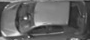

In [ ]:
cv2_imshow(crop_img)

In [ ]:
scale = 0.01791  # Ölçek faktörü